In [2]:
%%capture
!pip install wandb

In [73]:
import wandb
wandb.login()
wandb.init(project='DCGAN', name='Experiment3')

config = wandb.config
config.BUFFER_SIZE = 60000
config.BATCH_SIZE = 128
config.EPOCHS = 20
config.noise_dim = 100
config.num_to_generate = 16
config.precision = 'float16'

wandb.config.update(config)

In [3]:
import matplotlib.pyplot as plt
import os
import time

import tensorflow as tf
from tensorflow.keras import layers

In [74]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [76]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(config.precision)
train_images = (train_images - 127.5) /127.5

In [75]:
# BUFFER_SIZE = 60000
# BATCH_SIZE = 256

In [77]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(config.BUFFER_SIZE).batch(config.BATCH_SIZE)

In [79]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

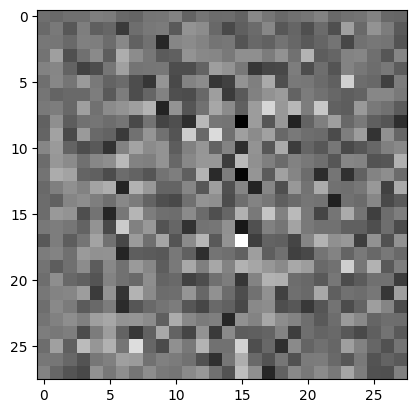

In [80]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [81]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [82]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00016108]], shape=(1, 1), dtype=float32)


In [83]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [84]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [85]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [86]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [87]:
# EPOCHS = 1
# noise_dim = 100
# num_to_generate = 16

seed = tf.random.normal([config.num_to_generate, config.noise_dim])

In [88]:
@tf.function
def train_step(images):
    noise = tf.random.normal([config.BATCH_SIZE, config.noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [89]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      wandb.log({'Discriminator Loss': disc_loss, 'Generator Loss': gen_loss})

    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  generate_and_save_images(generator,
                           epochs,
                           seed)

In [90]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  img = 'image_at_epoch_{:04d}.png'.format(epoch)
  plt.savefig(img)
  plt.show()

  wandb.log({"Images": [wandb.Image(img, caption=f'Epoch {epoch}')]})

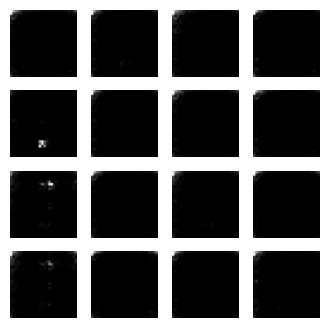

Time for epoch 1 is 21.08741044998169 sec


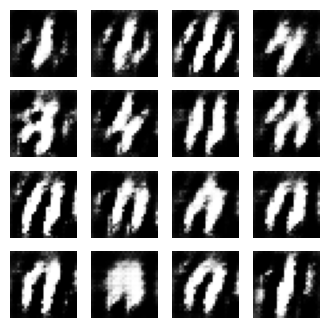

Time for epoch 2 is 12.120797395706177 sec


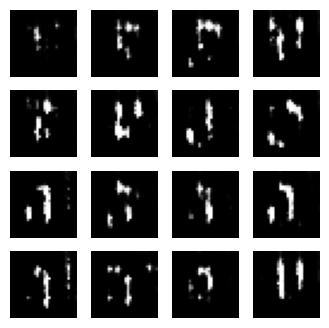

Time for epoch 3 is 13.005359172821045 sec


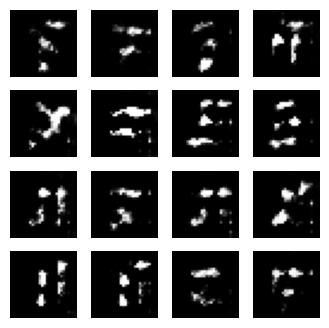

Time for epoch 4 is 21.37273359298706 sec


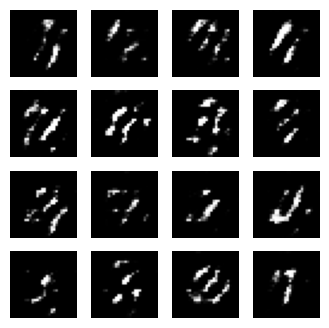

Time for epoch 5 is 21.340795755386353 sec


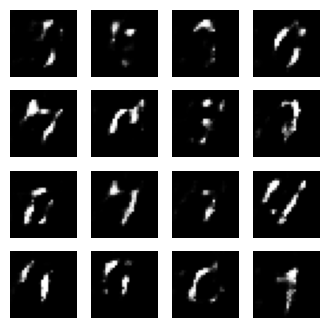

Time for epoch 6 is 12.404276609420776 sec


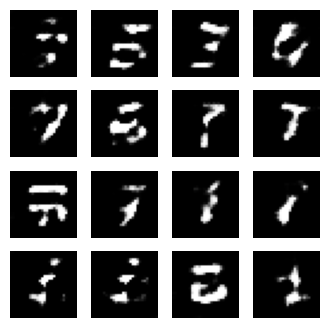

Time for epoch 7 is 12.273086786270142 sec


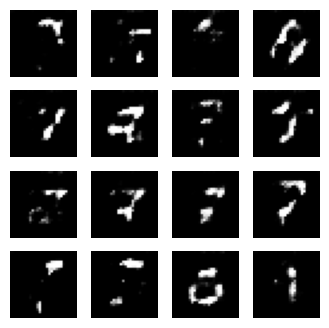

Time for epoch 8 is 12.223729848861694 sec


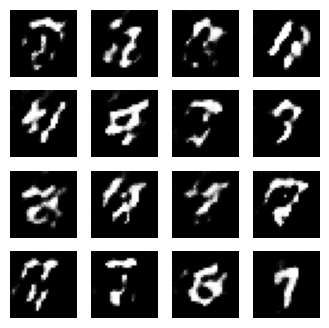

Time for epoch 9 is 12.7017982006073 sec


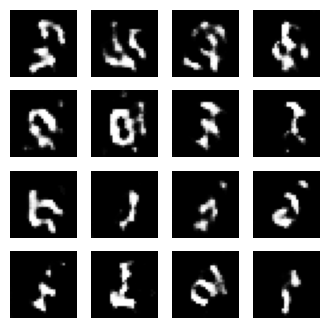

Time for epoch 10 is 21.017160415649414 sec


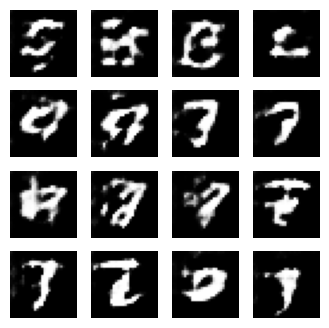

Time for epoch 11 is 12.367296695709229 sec


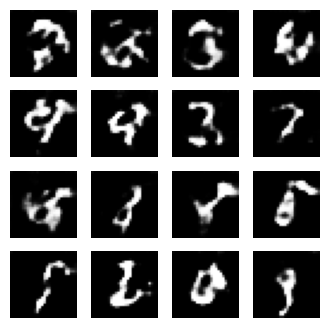

Time for epoch 12 is 12.31660008430481 sec


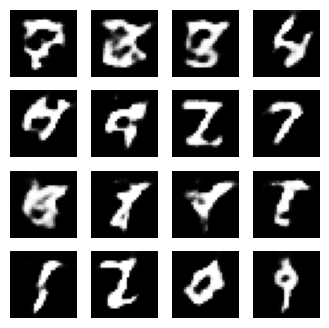

Time for epoch 13 is 12.398840427398682 sec


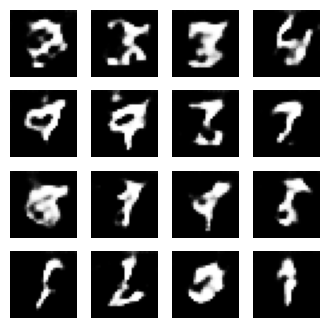

Time for epoch 14 is 21.035111904144287 sec


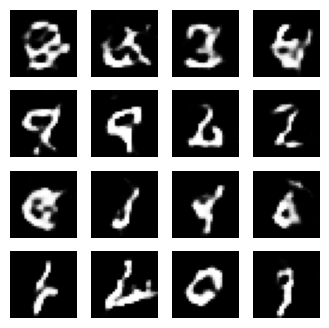

Time for epoch 15 is 21.436397314071655 sec


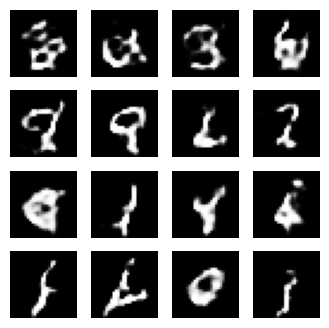

Time for epoch 16 is 21.071497917175293 sec


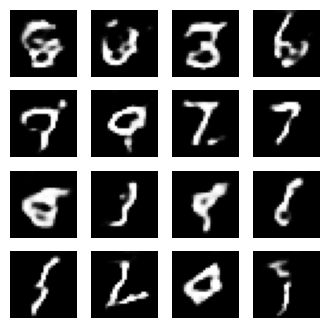

Time for epoch 17 is 21.033031463623047 sec


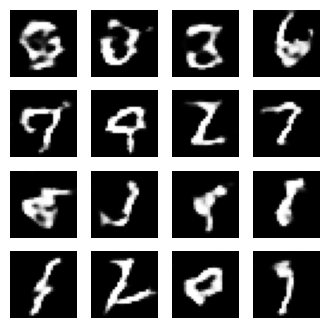

Time for epoch 18 is 21.023081064224243 sec


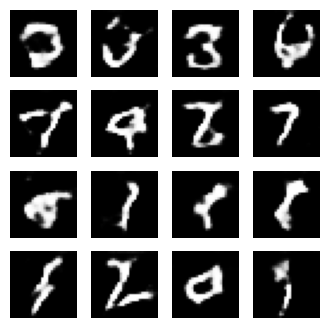

Time for epoch 19 is 12.389415979385376 sec


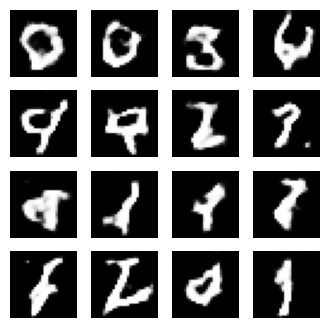

Time for epoch 20 is 21.77133059501648 sec


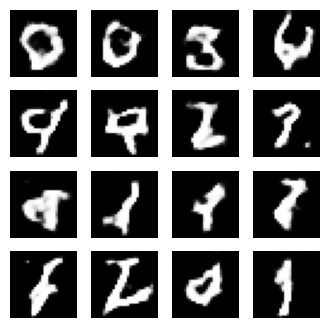

Discriminator Loss,▄▆▂▆▄▇▇█▇▆▄▃▄▄▇▅▄▃▁▂▇▁▂▄▂▆▃▄▄▄▃▃▅▅▃▅▄▅▅▆
Generator Loss,▂▁▄▂▄▂▁▁▁▂▃▅▃▃▃▄▅▇▆▅▃█▆▄▆▄▅▅▅▄▆▅▅▃▆▃▄▃▄▃
Discriminator Loss,0.89554
Generator Loss,1.46099


In [91]:
train(train_dataset, config.EPOCHS)
wandb.finish()